# Alzheimer prediction using gray matter density from T1w MRI 

**DataSet**: 

We will use a dataset composed of neuroimaging features from brain T1w MR images of 752 subjects, 416 controls and 336 with Alzheimer’s disease. Following the pipeline described in [1], all images are first normalized to a
common space, providing a voxel-wise correspondence across subjects. Then, gray matter density is computed at each voxel and averaged over a set of ROIs (Region of Interest) of an atlas, at the beginning we will use the [AAL2 atlas](http://www.gin.cnrs.fr/en/tools/aal/). 

Data comes from several freely available datasets, like [ADNI](http://adni.loni.usc.edu/) and [OASIS](https://www.oasis-brains.org/), and has been pre-processed by the [Clinica](http://www.clinica.run/) team using the procedure explained in [1].

we will  load *dataTP.npz* where :
- *T1x* is a matrix containing the averaged density (each row is a subject and each column a feature), 
- *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients)
- *ROIlabelsx* contains the name of the ROI of each feature. 

$\implies$ Here, *x* can take the name of the three atlases we  have at our disposal: AAL2, [AICHA](http://www.gin.cnrs.fr/fr/outils/aicha/), [HAMMERS](https://brain-development.org/brain-atlases/adult-brain-atlases/).



**Reference**:


[1] J. Samper-González, N. Burgos, S. Bottani, S. Fontanella, P. Lu, A. Marcoux, A. Routier, J. Guillon, M. Bacci, J. Wen, A. Bertrand, H. Bertin, M.-O. Habert, S. Durrleman, T. Evgeniou, O. Colliot. *Reproducible evaluation of classification methods in Alzheimer's disease: framework and application to MRI and PET data*. NeuroImage, 2018 

In [22]:
import warnings
warnings.filterwarnings("ignore")
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

# Libraries
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
#!pip3 install -q nilearn
from sklearn.model_selection import train_test_split
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='11cQmPm64k3T7ml5fPLetZgb1j1AjHBH8',
dest_path='.data/dataTP.npz')
gdd.download_file_from_google_drive(file_id='1S7e5IrPygE4VV0JTwqJIlyO2S_NhsiI4',
dest_path='.data/AtlasAAL2.nii')
gdd.download_file_from_google_drive(file_id='1E0pu5jIMpgcs2DQ8lBGWliwEBZvKrnV9',
dest_path='.data/AtlasAICHA.nii')
gdd.download_file_from_google_drive(file_id='1yltKwULrkHYh79RAh_zAg08r8pQMjRlQ',
dest_path='.data/AtlasHAMMERS.nii')

with np.load('.data/dataTP.npz',allow_pickle=True) as data:
    T1AAL2 = data['T1AAL2'] # data from AAL2 Atlas
    T1AICHA = data['T1AICHA'] # data from AICHA Atlas
    T1HAMMERS = data['T1HAMMERS'] # data from HAMMERS Atlas  
    y = data['y'] # classes, 0 for controls and 1 for patients    
    ROIlabelsAAL2 = data['ROIlabelsAAL2'] # labels for ROIs of atlas AAL2 
    ROIlabelsAICHA = data['ROIlabelsAICHA']    # labels for ROIs of atlas AICHA 
    ROIlabelsHAMMERS = data['ROIlabelsHAMMERS']    # labels for ROIs of atlas HAMMERS 

In [2]:
# Choose Atlas (here AAL2)
X=T1AAL2
labels=ROIlabelsAAL2
atlas='./AtlasAAL2.nii'

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI is: {0}'.format(M))
S

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI is: 120


Using the library nilearn we can also plot the atlas used to define the ROIs:

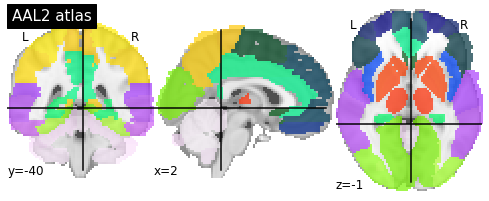

In [3]:
plotting.plot_roi(atlas, title="AAL2 atlas")
plotting.show()

In this notebook we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to scale the features so that each feature will have average equal to 0 and unit variance and create a training and test set.

In [4]:
    scaler=preprocessing.StandardScaler() 
scaler.fit(X)
scaler.transform(X)
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Then, we can fit a Decision tree, with the default setting, using the following code:

In [5]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Fitting Decision Trees with maximum depth equal to 4 (to keep the output simple)
Tree = DecisionTreeClassifier(max_depth=4)
Tree.fit(X_train,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )
# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 0.8652246256239601
Score in the test set is 0.7748344370860927


Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 


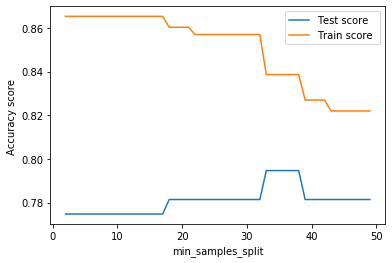

the optimal min_samples_split in the range [2,50] is  31


In [6]:
# 'min_samples_split'
TTest=[]
TTrain=[]
hyper_param= list ( range ( 2, 50))
for h_p in hyper_param: 
  Tree = DecisionTreeClassifier(max_depth=4,min_samples_split=h_p)
  Tree.fit(X_train,y_train)
  TTrain.append(Tree.score(X_train,y_train)) 
  TTest.append(Tree.score(X_test,y_test))


plt.plot(hyper_param, TTest, label='Test score')
plt.plot(hyper_param, TTrain, label='Train score ')
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy score ")
plt.legend()
plt.show()

print("the optimal min_samples_split in the range [2,50] is ", np.argmax(np.array(TTest))) 
min_samples_split=np.argmax(np.array(TTest))

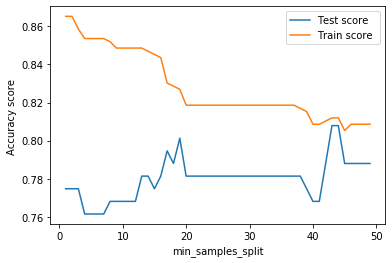

the optimal min_samples_leaf in the range [2,50] is  42


In [7]:
# 'min_samples_leaf'
TTest=[]
TTrain=[]
hyper_param= list ( range ( 1, 50))
for h_p in hyper_param: 
  Tree = DecisionTreeClassifier(max_depth=4,min_samples_leaf=h_p)
  Tree.fit(X_train,y_train)
  TTrain.append(Tree.score(X_train,y_train)) 
  TTest.append(Tree.score(X_test,y_test))


plt.plot(hyper_param, TTest, label='Test score')
plt.plot(hyper_param, TTrain, label='Train score ')
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy score ")
plt.legend()
plt.show()

print("the optimal min_samples_leaf in the range [2,50] is ", np.argmax(np.array(TTest))) 
min_samples_leaf=np.argmax(np.array(TTest))


* The training accuracy decreases if the paramters ['min_samples_leaf','min_samples_split'] increases
* the test accuracy increases if the paramters ['min_samples_leaf','min_samples_split'] increases.
=> It is  an overfitting case. that is because when we decide only a small number of samples can be put in a leaf then we are overfitting the model because the leafs fits particular cases. The model is not learning but fiiting to the training data so tightly.




In order to verify if our  results are stable or not we will try to add Gaussian noise to the data (using for instance zero mean and 0.5 for the std) and, using the best hyperparameters found before, look at the test score. Repeat this process several times nd compare the results with the score obtained without adding noise.

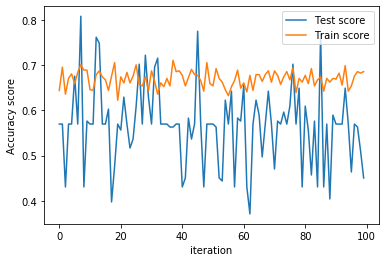

In [8]:
TTest=[]
TTrain=[]
for iteration in range(100):
  NX_train = X_train + np.random.normal(0, 0.5, size=X_train.shape)
  Tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
  Tree.fit(NX_train,y_train)
  TTrain.append(Tree.score(NX_train,y_train))
  TTest.append(Tree.score(X_test,y_test))

plt.plot(list(range(100)), TTest, label='Test score')
plt.plot(list(range(100)), TTrain, label='Train score')
plt.xlabel("iteration")
plt.ylabel("Accuracy score")
plt.legend()
plt.show()

$\implies$The results are not stable, A small change in input data  can bring a completely different tree  and thus make the model test accuracy flactuate.This instability is due to the hierarchical nature of the process of creating decision trees.

To plot decision trees, we can also use the *graphviz* library.

First plot the tree learnt on the original data, witout adding noise.

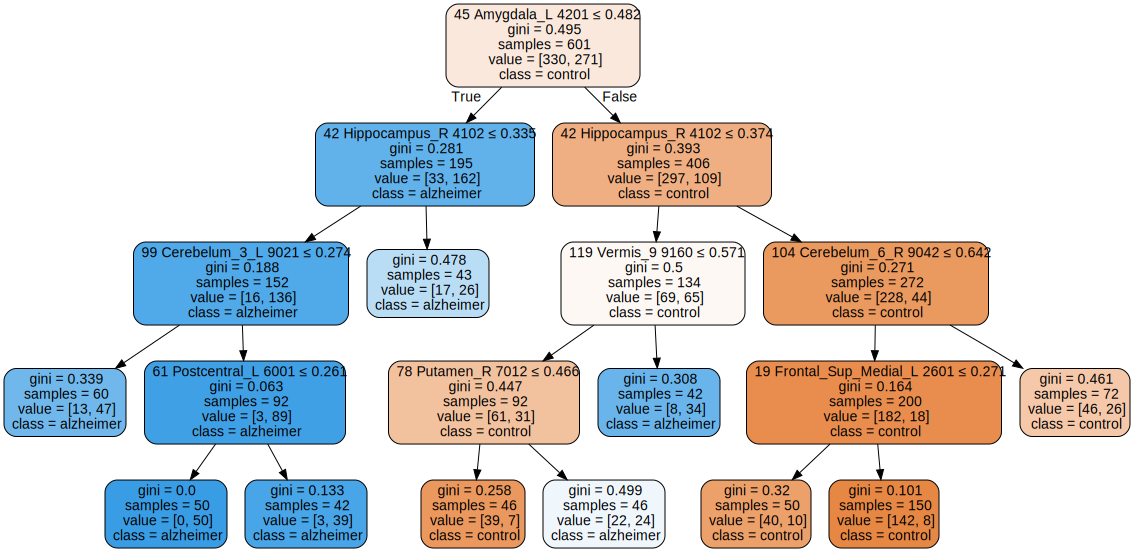

In [17]:
import graphviz 

Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Now,  we will try to undrstand why noise ruin our model , we will plot the tree learnt on noisy data. 

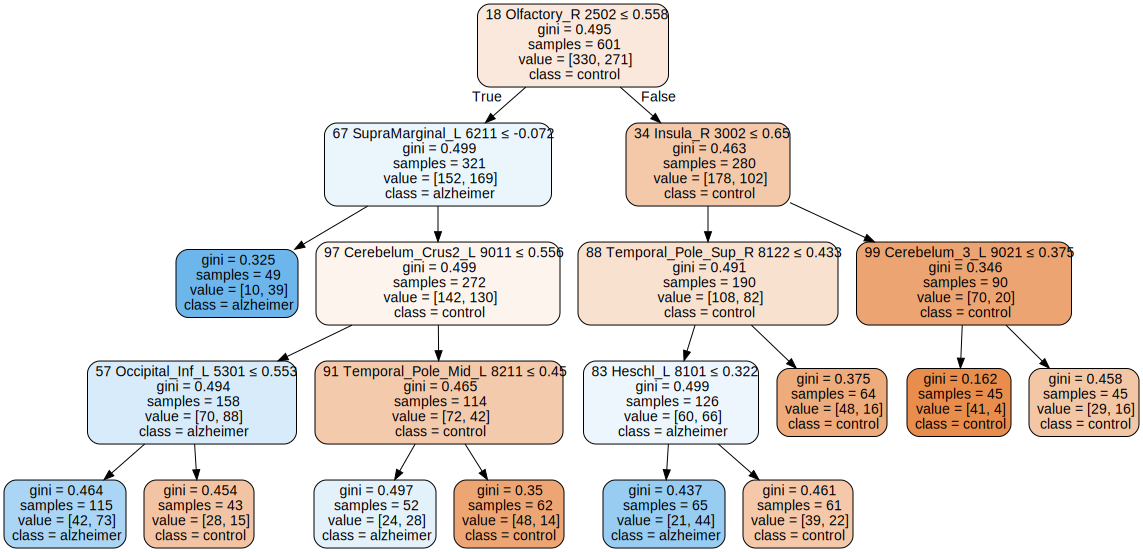

In [18]:
import graphviz 
NX_train = X_train + np.random.normal(0, 0.5, size=X_train.shape)
Tree.fit(NX_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

we tried many noise std values and each timeweI get a different decision tree.This is due to the fact that the decision trees are not stable. 
But, we can conclude that the features: 
- '46 Amygdala_R'
- '42 Hippocampus_R'
- '41 Hippocampus_L'
- '42 Hippocampus_R'
- '45 Amygdala_L'

are the most important ones because they usualy appear on the root of the tree.

Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values for both 'min_samples_split' and 'min_samples_leaf' at the same time and in an automatic way.

In [19]:
from sklearn.model_selection import GridSearchCV


# Looking for the best hyperparameters
hyper_param = {'min_samples_leaf':list(range(1,20)), 'min_samples_split':list(range(2,30))}
Tree = DecisionTreeClassifier(max_depth=4)
grid = GridSearchCV(Tree, hyper_param, cv=5, n_jobs=-1)
grid.fit(X_train, np.ravel(y_train))

print('The optimal min_samples_split is [with CV = ', grid.best_params_.get('min_samples_split'),'] and [ without CV = ',min_samples_split,']')
print('The optimal min_samples_leaf is [with CV = ', grid.best_params_.get('min_samples_leaf'),'] and [ without CV = ',min_samples_leaf,']')



The optimal min_samples_split is [with CV =  6 ] and [ without CV =  31 ]
The optimal min_samples_leaf is [with CV =  10 ] and [ without CV =  42 ]


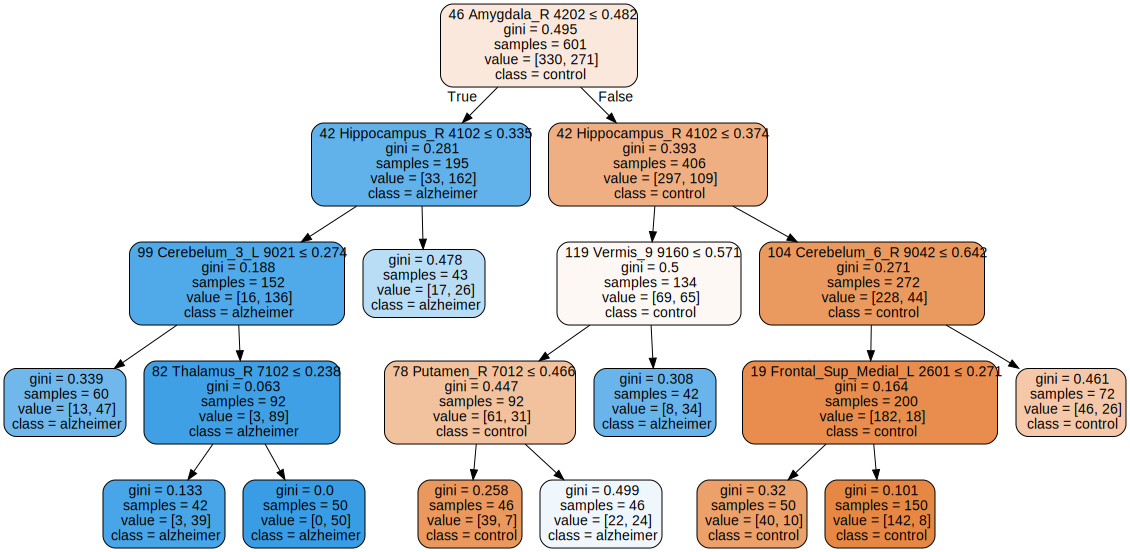

In [20]:

best_split = grid.best_params_.get('min_samples_split')
best_leaf = grid.best_params_.get('min_samples_leaf') 
Tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

As we expected before these features ['42 Hippocampus_R'  '42 Hippocampus_R', '45 Amygdala_L'] apprears again as root and second level nodes in the tree so they should be one of the most important features.

### Bagging 

In [23]:
from sklearn.ensemble import BaggingClassifier

Tree = DecisionTreeClassifier(criterion="gini",min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split, random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, scoring="accuracy", cv=5)
print("Orignal Data")
grid_bagging.fit(X_train, y_train)
print("Best Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging score :",grid_bagging.score(X_test,y_test))
print("Data + Noise ")
grid_bagging.fit(NX_train, y_train)
print("Best Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging score :",grid_bagging.score(X_test,y_test))

Orignal Data
Best Score: 0.7803305785123966
Best params: {'n_estimators': 15}
Bagging score : 0.8145695364238411
Data + Noise 
Best Score: 0.5573829201101927
Best params: {'n_estimators': 15}
Bagging score : 0.7417218543046358



$\implies$The idea of bagging is to overcome the problem of trees that suffer from high variance,  same model applied to two slightly diffrent training sets can give very different results. the results of bagging are more stable and accurate than the original tree and it is more useful in the case of noisy data.

### RandomForest 

In [24]:
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(criterion="gini", random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train, y_train)
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

Best Score: 0.8302617079889807
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 6, 'n_estimators': 20}


In [25]:
RF=RandomForestClassifier(criterion="gini",
                          random_state=0,
                          n_estimators =grid_RF.best_params_["n_estimators"] ,
                          min_samples_leaf = grid_RF.best_params_["min_samples_leaf"],
                          max_features =grid_RF.best_params_["max_features"])
RF.fit(NX_train, np.ravel(y_train))
# Score in the training set
print('Score in the noisy training set is {0}'.format(RF.score(NX_train,y_train)) )
# Score in the test set
print('Score in the noisy test set is {0}'.format(RF.score(X_test,y_test)) )

Score in the noisy training set is 0.9850249584026622
Score in the noisy test set is 0.5629139072847682


$\implies$Random forest as well as bargging shows good performance  and strength against the noisy data compared to the signle decision tree.

Random forest gives slightly better results on our testing set than the bragging methode. 

We can also use Random Forests to check the importance of the features and do feature selection 

Feature ranking:
1. feature 45 representing 46 Amygdala_R 4202
 (0.120779)
2. feature 40 representing 41 Hippocampus_L 4101
 (0.093157)
3. feature 41 representing 42 Hippocampus_R 4102
 (0.051080)
4. feature 93 representing 94 Temporal_Inf_R 8302
 (0.046640)
5. feature 43 representing 44 ParaHippocampal_R 4112
 (0.045298)
6. feature 92 representing 93 Temporal_Inf_L 8301
 (0.039497)
7. feature 44 representing 45 Amygdala_L 4201
 (0.035876)
8. feature 59 representing 60 Fusiform_R 5402
 (0.026609)
9. feature 42 representing 43 ParaHippocampal_L 4111
 (0.020067)
10. feature 81 representing 82 Thalamus_R 7102
 (0.016287)


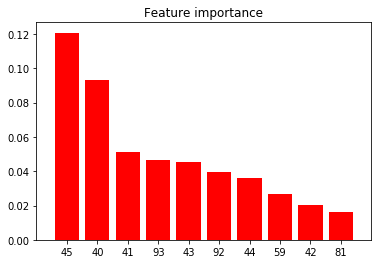

In [26]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(criterion="gini",min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

$\implies$
The most important features  are '46 Amygdala_R' and '41 Hippocampus_L', and we already made the assumption that these features are  ones of the most important ones in the features set ( because they appreared alot of times as roots or the tree or second level split node ), and using random forest we can see that it selected 46/40/41 features  which is in in accordance with the papers conclusions. 

We can also inspect the data using only pairs of the most important features

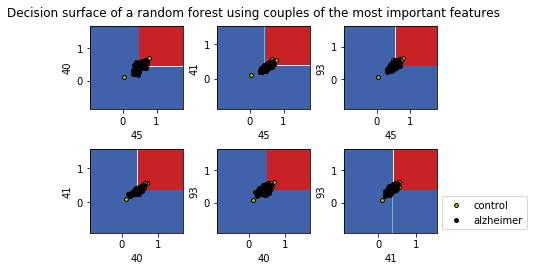

In [27]:
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "yk"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()



$\implies$The best couple is the couple that separates the sampless into almost contrik samples and almost alzheimer samples. In this case the couple (45,93) makes less missclassifications so it is the best couple. 

**Different Atlas**

Previously, we have used the AAL2 which defines a precise split of the brain into ROIs.
What happens if we change Atlas ? Do we obtain the same results ? Can we find a subset of ROIs that you could define 'biomarkers' of the Alzheimer's disease ?

Best Score: 0.8301790633608815
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 30}
Ranking: 
3 Right Amygdala                         0.1089489441316059
2 Left Amygdala                          0.07190445742295767
0 Left Hippocampus                       0.05521013451486387
1 Right Hippocampus                      0.05063440547286875
12 Left Inferior Middle Temporal Gyri     0.04586963927928692
46 Left Lateral Temporal Ventricle        0.04527164679775431
47 Right Lateral Temporal Ventricle       0.04044690631828836
41 Right Thalamus                         0.024961429128822696
4 Left Anterior Medial Temporal Lobe     0.023283698495287032
8 Left Ambient and Parahippocampus Gyri  0.01894917865307325


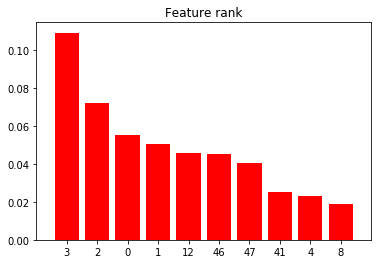

In [35]:
# Choosing an Atlas
X=T1HAMMERS
labels=ROIlabelsHAMMERS
atlas='./AtlasHAMMERS.nii'
# Scale the features (each feature will have average equal to 0 and unit variance)
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.2, random_state=42)

#RandomForestClassifier
RF=RandomForestClassifier(criterion="gini", random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 
             'min_samples_leaf': [2,3,4,5,6],
             'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train, y_train)
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

#Rank features by importance
RF = RandomForestClassifier(criterion="gini",min_samples_leaf=grid_RF.best_params_["min_samples_leaf"],
                            max_features=grid_RF.best_params_["max_features"],
                            n_estimators=grid_RF.best_params_["n_estimators"], 
                            random_state=0)
RF.fit(X_train, np.ravel(y_train))

# Print the feature rankin


importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

print("Ranking: ")

for ft in range(10):
    print(indices[ft], labels[ np.argsort(importances)[::-1][ft]], RF.feature_importances_[ np.argsort(importances)[::-1][ft]])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature rank")
plt.bar(range(10),  RF.feature_importances_[ np.argsort(importances)[::-1][0:10]], color="r", align="center")
plt.xticks(range(10), np.argsort(importances)[::-1][0:10])
plt.xlim([-1, 10])
plt.show()

In [58]:
dot_data = tree.export_graphviz(RF.estimators_[0], out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph.save()

'Source.gv'

In [59]:
from subprocess import check_call
check_call(['dot','-Tpng','Source.gv','-o','OutputFile.png'])

0

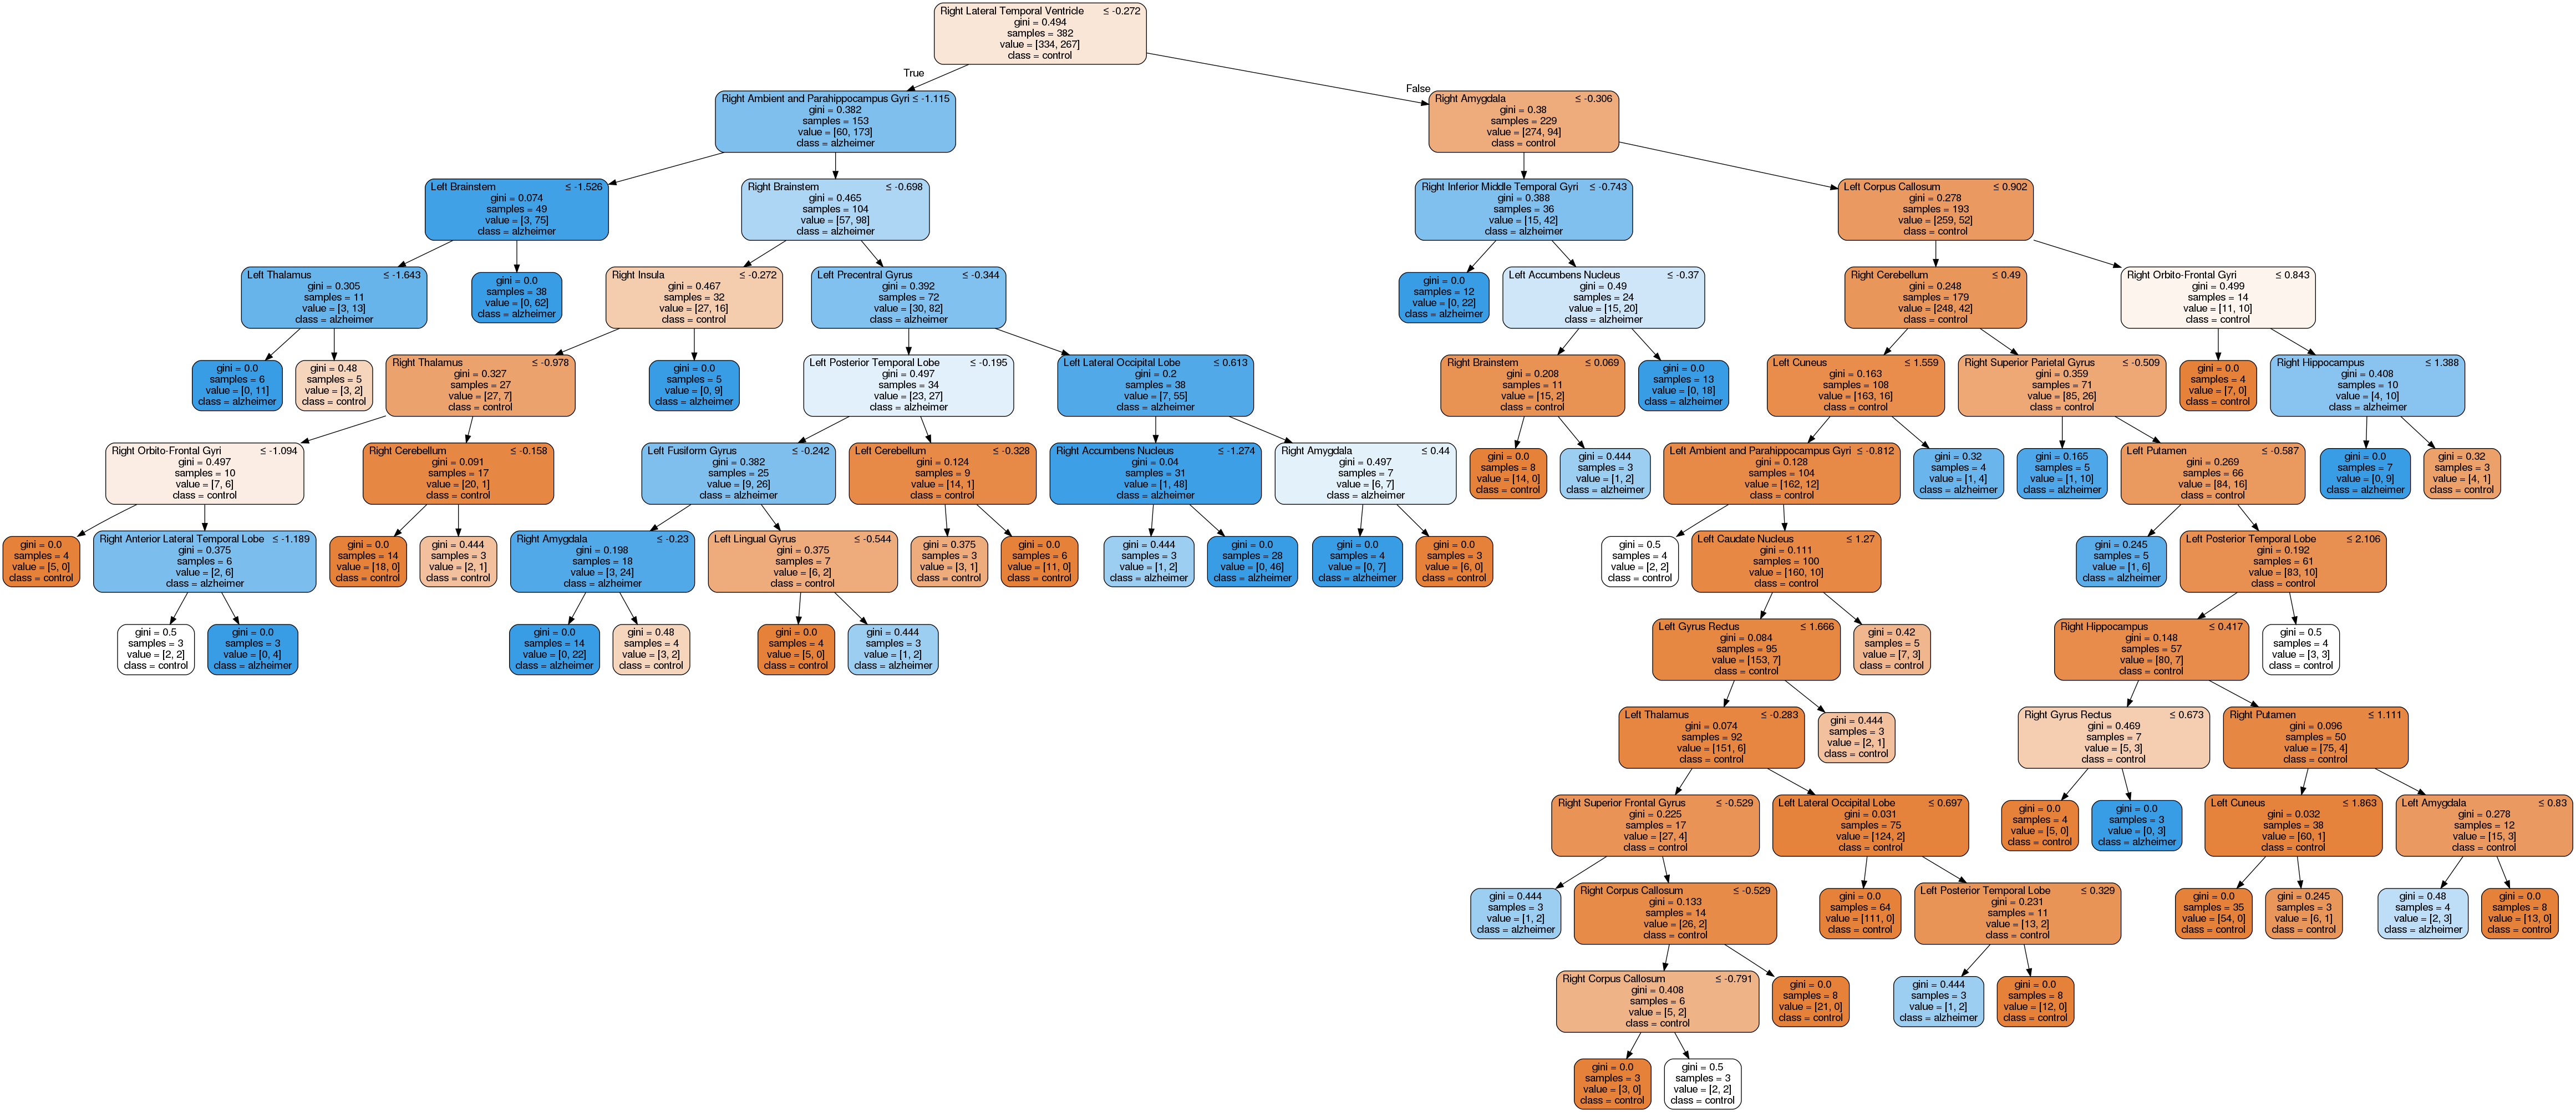

In [60]:

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'OutputFile.png')

In [ ]:
t